## 1. Setup and Data Loading <a id="1-setup"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Load all annotation files
data_dir = Path('../data/annotator-results')

# Human annotators
human_annotators = ['A', 'B', 'C']
human_data = {}
for annotator in human_annotators:
    file_path = data_dir / f'annotations_{annotator}.csv'
    df = pd.read_csv(file_path)
    human_data[annotator] = df
    print(f"Loaded {annotator}: {len(df)} annotations")

# LLM annotators
llm_files = [
    'annotations_ollama_deepseek-r1_14b.csv',
    'annotations_ollama_mistral_7b.csv',
    'annotations_ollama_gemma3_12b.csv',
    'annotations_ollama_qwen3-coder_30b.csv',
    'annotations_ollama_gpt-oss_20b.csv',
    'annotations_ollama_codellama_13b.csv',
    'annotations_ollama_llama3.1_8b.csv'
]

llm_data = {}
for file in llm_files:
    # Extract clean LLM name from filename
    llm_name = file.replace('annotations_ollama_', '').replace('.csv', '').replace('_', ' ')
    df = pd.read_csv(data_dir / file)
    llm_data[llm_name] = df
    print(f"Loaded {llm_name}: {len(df)} annotations")

Loaded A: 911 annotations
Loaded B: 1000 annotations
Loaded C: 911 annotations
Loaded deepseek-r1 14b: 50 annotations
Loaded mistral 7b: 50 annotations
Loaded gemma3 12b: 50 annotations
Loaded qwen3-coder 30b: 50 annotations
Loaded gpt-oss 20b: 50 annotations
Loaded codellama 13b: 50 annotations
Loaded llama3.1 8b: 50 annotations


In [3]:
# Define categories and create unified dataset
categories = ['bfc', 'bpc', 'prc', 'nfc']

def prepare_unified_data(human_data, llm_data, categories):
    """
    Create a unified dataset with all annotations.
    Returns a dictionary: {category: DataFrame with columns [hash, A, B, C, llm1, llm2, ...]}
    """
    unified = {}
    
    for category in categories:
        # Start with human annotations
        category_df = human_data['A'][['hash', category]].rename(columns={category: 'A'}).copy()
        
        # Add human annotator columns
        for annotator in ['B', 'C']:
            df = human_data[annotator]
            category_df = category_df.merge(
                df[['hash', category]].rename(columns={category: annotator}),
                on='hash',
                how='inner'
            )
        
        # Add LLM columns
        for llm_name, df in llm_data.items():
            category_df = category_df.merge(
                df[['hash', category]].rename(columns={category: llm_name}),
                on='hash',
                how='inner'
            )
        
        # Drop rows with missing values (should not be needed with inner joins, but as safety)
        category_df = category_df.dropna()
        unified[category] = category_df
        
        print(f"{category.upper()}: {len(category_df)} commits with complete annotations")
    
    return unified

unified_data = prepare_unified_data(human_data, llm_data, categories)

BFC: 50 commits with complete annotations
BPC: 50 commits with complete annotations
PRC: 50 commits with complete annotations
NFC: 50 commits with complete annotations


### Epsilon (ε) Selection: Cost-Benefit Hyperparameter

Before proceeding with the analysis, we need to set the **cost-benefit hyperparameter ε**, which adjusts the threshold the LLM must exceed in the alt-test.

#### Why Use ε > 0?

LLMs offer a **cheaper, faster, and less labor-intensive** alternative to human annotators. The hyperparameter ε accounts for this advantage by lowering the threshold the LLM must beat (ρ^h_j - ε instead of ρ^h_j).

#### Rule of Thumb for Setting ε:

1. **ε = 0.2**: For trusted experts or highly reliable annotators
2. **ε = 0.15**: For skilled annotators (e.g., undergraduate students, trained workers)
3. **ε = 0.1**: For crowd workers or annotators with low reliability

#### Effective Range:
- **ε > 0.3**: Almost all LLMs pass (too lenient)
- **0.05 ≤ ε ≤ 0.3**: Effective range with meaningful discrimination
- **ε < 0.05**: Almost all LLMs fail (too strict)

#### Our Choice:

**ε = 0.15** (skilled annotators)

**Justification**:
- Human annotators in this study are graduate-level researchers
- They received training on commit classification methodology
- The annotation task requires domain knowledge (software engineering, Linux kernel)
- This is not a simple task for untrained crowd workers
- Moderate IAA suggests skilled but not expert-level annotators

We will also test **ε = 0.1** and **ε = 0.2** for sensitivity analysis.

In [4]:
# Configuration: Epsilon values to test
EPSILON_PRIMARY = 0.15  # Primary epsilon for skilled annotators
EPSILON_SENSITIVITY = [0.1, 0.15, 0.2]  # Sensitivity analysis
ALPHA = 0.05  # Significance level

print(f"Primary epsilon (ε): {EPSILON_PRIMARY}")
print(f"Sensitivity analysis: ε ∈ {EPSILON_SENSITIVITY}")
print(f"Significance level (α): {ALPHA}")
print(f"\nJustification: Graduate-level researchers with training (skilled annotators)")
print(f"              → ε = {EPSILON_PRIMARY} is appropriate")

Primary epsilon (ε): 0.15
Sensitivity analysis: ε ∈ [0.1, 0.15, 0.2]
Significance level (α): 0.05

Justification: Graduate-level researchers with training (skilled annotators)
              → ε = 0.15 is appropriate


In [5]:
# Display sample data
print("\nSample data for BFC category:")
display(unified_data['bfc'].head())

print("\nDataset shapes:")
for cat in categories:
    print(f"{cat.upper()}: {unified_data[cat].shape}")


Sample data for BFC category:


,hash,A,B,C,deepseek-r1 14b,mistral 7b,gemma3 12b,qwen3-coder 30b,gpt-oss 20b,codellama 13b,llama3.1 8b
0,3044a4f271,0,0,0,0,0,0,0,0,0,0
1,e1553351d7,0,0,0,0,0,0,0,0,4,0
2,2fadc6ea4a,0,0,0,0,0,0,0,0,0,0
3,805a3ebed5,0,0,0,0,0,0,0,0,0,0
4,9b51d9d866,0,0,0,0,0,0,0,0,0,0



Dataset shapes:
BFC: (50, 11)
BPC: (50, 11)
PRC: (50, 11)
NFC: (50, 11)


## 2. Scoring Functions <a id="2-scoring"></a>

We implement two alignment scoring functions:

### Accuracy (ACC)
For discrete annotations (appropriate for Likert scale 0-4):
$$ACC(f, x_i, j) = \frac{1}{|H_i| - 1} \sum_{k \in H_i[-j]} 1\{f(x_i) = h_k(x_i)\}$$

### Negative RMSE
For continuous/ordinal annotations:
$$-RMSE(f, x_i, j) = - \sqrt{\frac{1}{|H_i| - 1} \sum_{k \in H_i[-j]} (f(x_i) - h_k(x_i))^2}$$

We'll use **negative RMSE** as it's more appropriate for ordinal Likert scales.

In [6]:
def compute_acc_score(f_annotation, other_annotations):
    """
    Compute accuracy alignment score.
    
    Args:
        f_annotation: Single annotation value (from LLM or excluded human)
        other_annotations: Array of annotations from other humans
    
    Returns:
        Accuracy score (proportion of exact matches)
    """
    return np.mean(f_annotation == other_annotations)

def compute_rmse_score(f_annotation, other_annotations):
    """
    Compute negative RMSE alignment score.
    
    Args:
        f_annotation: Single annotation value (from LLM or excluded human)
        other_annotations: Array of annotations from other humans
    
    Returns:
        Negative RMSE score (higher is better)
    """
    return -np.sqrt(np.mean((f_annotation - other_annotations) ** 2))

# Test the scoring functions
test_f = 3
test_others = np.array([3, 2, 4])
print(f"Test annotation: f={test_f}, others={test_others}")
print(f"ACC score: {compute_acc_score(test_f, test_others):.3f}")
print(f"RMSE score: {compute_rmse_score(test_f, test_others):.3f}")

Test annotation: f=3, others=[3 2 4]
ACC score: 0.333
RMSE score: -0.816


## 3. Advantage Probability Computation <a id="3-advantage"></a>

We compute advantage probabilities using the leave-one-out approach:

### For each instance $x_i$ and excluded annotator $h_j$:

1. Compute $S(f, x_i, j)$: LLM's alignment with remaining humans
2. Compute $S(h_j, x_i, j)$: Excluded human's alignment with remaining humans
3. Define indicator:
$$W^{f}_{i,j} = \begin{cases} 1, & \text{if } S(f, x_i, j) \geq S(h_j, x_i, j) \\ 0, & \text{otherwise} \end{cases}$$

4. Estimate advantage probability:
$$\rho^f_j = \frac{1}{|I_j|} \sum_{i \in I_j} W^{f}_{i,j}$$

In [7]:
def compute_advantage_probabilities(df, llm_name, human_annotators, score_func=compute_rmse_score):
    """
    Compute advantage probabilities for a single LLM against all human annotators.
    
    Args:
        df: DataFrame with columns [hash, A, B, C, llm_name]
        llm_name: Name of the LLM column
        human_annotators: List of human annotator names
        score_func: Scoring function to use (compute_rmse_score or compute_acc_score)
    
    Returns:
        Dictionary with results for each excluded human:
        {human_j: {'rho_f': prob_llm_wins, 'rho_h': prob_human_wins, 'W_f': indicators_llm, 'W_h': indicators_human}}
    """
    results = {}
    
    for excluded_human in human_annotators:
        # Get remaining humans
        remaining_humans = [h for h in human_annotators if h != excluded_human]
        
        W_f_list = []  # Indicators for LLM winning
        W_h_list = []  # Indicators for human winning
        
        # For each instance (commit)
        for idx, row in df.iterrows():
            # Get annotations
            llm_annotation = row[llm_name]
            excluded_annotation = row[excluded_human]
            remaining_annotations = row[remaining_humans].values
            
            # Compute alignment scores
            S_llm = score_func(llm_annotation, remaining_annotations)
            S_human = score_func(excluded_annotation, remaining_annotations)
            
            # Compute indicators
            W_f = 1 if S_llm >= S_human else 0
            W_h = 1 if S_human >= S_llm else 0
            
            W_f_list.append(W_f)
            W_h_list.append(W_h)
        
        # Compute advantage probabilities
        rho_f = np.mean(W_f_list)
        rho_h = np.mean(W_h_list)
        
        results[excluded_human] = {
            'rho_f': rho_f,
            'rho_h': rho_h,
            'W_f': W_f_list,
            'W_h': W_h_list,
            'n_instances': len(W_f_list)
        }
    
    return results

In [8]:
# Test advantage probability computation for BFC category with one LLM
test_llm = list(llm_data.keys())[0]
test_results = compute_advantage_probabilities(
    unified_data['bfc'], 
    test_llm, 
    human_annotators
)

print(f"\nTest results for {test_llm} on BFC category:")
for human, res in test_results.items():
    print(f"  vs {human}: ρ^f={res['rho_f']:.3f}, ρ^h={res['rho_h']:.3f}, n={res['n_instances']}")


Test results for deepseek-r1 14b on BFC category:
  vs A: ρ^f=0.820, ρ^h=0.960, n=50
  vs B: ρ^f=0.820, ρ^h=0.940, n=50
  vs C: ρ^f=0.820, ρ^h=0.980, n=50


## 4. Statistical Testing <a id="4-testing"></a>

### Paired t-test
We test the hypothesis:
$$H_{0j}: \rho^f_j \leq \rho^h_j - \epsilon \quad \text{vs.} \quad H_{1j}: \rho^f_j > \rho^h_j - \epsilon$$

Using difference indicators: $d_{i,j} = W^{h}_{i,j} - W^{f}_{i,j}$

Test statistic:
$$t_j = \frac{\bar{d}_j - \epsilon}{s_j / \sqrt{n}}$$

### Benjamini-Yekutieli (BY) Correction
Control False Discovery Rate (FDR) for multiple comparisons.

In [9]:
def benjamini_yekutieli_correction(p_values, alpha=0.05):
    """
    Apply Benjamini-Yekutieli correction for FDR control.
    
    Uses statsmodels multipletests with 'fdr_by' method.
    
    Args:
        p_values: Array of p-values
        alpha: Significance level (default: 0.05)
    
    Returns:
        Array of boolean values indicating rejected hypotheses
    """
    rejected, _, _, _ = multipletests(p_values, alpha=alpha, method='fdr_by')
    return rejected

def perform_alt_test(advantage_results, epsilon=0.0, alpha=0.05):
    """
    Perform the Alternative Annotator Test with BY correction.
    
    Args:
        advantage_results: Results from compute_advantage_probabilities
        epsilon: Cost-benefit hyperparameter (default: 0.0)
        alpha: Significance level (default: 0.05)
    
    Returns:
        Dictionary with test results
    """
    test_results = {}
    p_values_list = []
    human_list = []
    
    for human, res in advantage_results.items():
        # Compute differences: d_i,j = W^h_i,j - W^f_i,j
        d = np.array(res['W_h']) - np.array(res['W_f'])
        n = len(d)
        d_bar = np.mean(d)
        s = np.std(d, ddof=1)
        
        # Compute t-statistic
        if s == 0:
            # Handle edge case where all differences are the same
            t_stat = np.inf if d_bar < epsilon else -np.inf
        else:
            t_stat = (d_bar - epsilon) / (s / np.sqrt(n))
        
        # One-tailed test (H1: rho_f > rho_h - epsilon, i.e., d_bar < epsilon)
        p_value = stats.t.cdf(t_stat, df=n-1)
        
        test_results[human] = {
            'rho_f': res['rho_f'],
            'rho_h': res['rho_h'],
            'd_bar': d_bar,
            's': s,
            't_stat': t_stat,
            'p_value': p_value,
            'n': n
        }
        
        p_values_list.append(p_value)
        human_list.append(human)
    
    # Apply BY correction
    p_values_array = np.array(p_values_list)
    rejected = benjamini_yekutieli_correction(p_values_array, alpha)
    
    # Add rejection information
    for i, human in enumerate(human_list):
        test_results[human]['rejected'] = rejected[i]
    
    # Compute winning rate
    winning_rate = np.mean(rejected)
    
    # Compute average advantage probability
    avg_advantage_prob = np.mean([res['rho_f'] for res in test_results.values()])
    
    return {
        'test_results': test_results,
        'winning_rate': winning_rate,
        'avg_advantage_prob': avg_advantage_prob,
        'can_replace': winning_rate >= 0.5
    }

In [10]:
# Test the alt-test with one LLM on BFC
test_alt_results = perform_alt_test(test_results, epsilon=EPSILON_PRIMARY, alpha=ALPHA)

print(f"\nAlt-Test results for {test_llm} on BFC (ε={EPSILON_PRIMARY}):")
print(f"  Winning Rate (ω): {test_alt_results['winning_rate']:.3f}")
print(f"  Avg Advantage Prob (ρ): {test_alt_results['avg_advantage_prob']:.3f}")
print(f"  Can replace humans: {test_alt_results['can_replace']}")
print("\nDetailed results:")
for human, res in test_alt_results['test_results'].items():
    print(f"  vs {human}: ρ^f={res['rho_f']:.3f}, p={res['p_value']:.4f}, rejected={res['rejected']}")


Alt-Test results for deepseek-r1 14b on BFC (ε=0.15):
  Winning Rate (ω): 0.000
  Avg Advantage Prob (ρ): 0.820
  Can replace humans: False

Detailed results:
  vs A: ρ^f=0.820, p=0.4382, rejected=False
  vs B: ρ^f=0.820, p=0.3302, rejected=False
  vs C: ρ^f=0.820, p=0.5662, rejected=False


## 5. Individual Category Analysis <a id="5-individual"></a>

We now perform the complete Alt-Test for each commit category (BFC, BPC, PRC, NFC) individually.

In [11]:
def analyze_llms_for_category(category_df, llm_names, human_annotators, epsilon=0.0, alpha=0.05):
    """
    Perform Alt-Test for all LLMs on a single category.
    
    Returns:
        DataFrame with results for all LLMs
    """
    results = []
    
    for llm_name in llm_names:
        # Compute advantage probabilities
        adv_probs = compute_advantage_probabilities(
            category_df, llm_name, human_annotators
        )
        
        # Perform alt-test
        alt_test = perform_alt_test(adv_probs, epsilon, alpha)
        
        # Store results
        result_row = {
            'LLM': llm_name,
            'Winning_Rate': alt_test['winning_rate'],
            'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
            'Can_Replace': alt_test['can_replace']
        }
        
        # Add per-human results
        for human in human_annotators:
            res = alt_test['test_results'][human]
            result_row[f'rho_f_vs_{human}'] = res['rho_f']
            result_row[f'p_value_vs_{human}'] = res['p_value']
            result_row[f'rejected_vs_{human}'] = res['rejected']
        
        results.append(result_row)
    
    return pd.DataFrame(results)

In [12]:
# Analyze all categories
category_results = {}
llm_names = list(llm_data.keys())

for category in categories:
    results_df = analyze_llms_for_category(
        unified_data[category],
        llm_names,
        human_annotators,
        epsilon=EPSILON_PRIMARY,
        alpha=ALPHA
    )
    category_results[category] = results_df

In [13]:
# Display results for each category
for category in categories:
    print(f"\n{'='*80}")
    print(f"{category.upper()} CATEGORY RESULTS")
    print(f"{'='*80}")
    
    df = category_results[category].sort_values('Avg_Advantage_Prob', ascending=False)
    
    # Display summary columns
    display_cols = ['LLM', 'Winning_Rate', 'Avg_Advantage_Prob', 'Can_Replace']
    display(df[display_cols])
    
    # Summary statistics
    n_can_replace = df['Can_Replace'].sum()
    print(f"\nSummary: {n_can_replace}/{len(df)} LLMs can replace human annotators (ω ≥ 0.5)")
    print(f"Best LLM: {df.iloc[0]['LLM']} (ρ = {df.iloc[0]['Avg_Advantage_Prob']:.3f})")


BFC CATEGORY RESULTS


,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
6,llama3.1 8b,1.0,0.92,True
4,gpt-oss 20b,0.0,0.90,False
2,gemma3 12b,0.0,0.88,False
3,qwen3-coder 30b,0.0,0.88,False
1,mistral 7b,0.0,0.86,False
5,codellama 13b,0.0,0.84,False
0,deepseek-r1 14b,0.0,0.82,False



Summary: 1/7 LLMs can replace human annotators (ω ≥ 0.5)
Best LLM: llama3.1 8b (ρ = 0.920)

BPC CATEGORY RESULTS


,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
0,deepseek-r1 14b,0.0,0.660000,False
4,gpt-oss 20b,0.0,0.586667,False
3,qwen3-coder 30b,0.0,0.573333,False
1,mistral 7b,0.0,0.533333,False
5,codellama 13b,0.0,0.486667,False
6,llama3.1 8b,0.0,0.466667,False
2,gemma3 12b,0.0,0.460000,False



Summary: 0/7 LLMs can replace human annotators (ω ≥ 0.5)
Best LLM: deepseek-r1 14b (ρ = 0.660)

PRC CATEGORY RESULTS


,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
4,gpt-oss 20b,0.0,0.846667,False
0,deepseek-r1 14b,0.0,0.626667,False
3,qwen3-coder 30b,0.0,0.540000,False
5,codellama 13b,0.0,0.460000,False
2,gemma3 12b,0.0,0.440000,False
1,mistral 7b,0.0,0.380000,False
6,llama3.1 8b,0.0,0.340000,False



Summary: 0/7 LLMs can replace human annotators (ω ≥ 0.5)
Best LLM: gpt-oss 20b (ρ = 0.847)

NFC CATEGORY RESULTS


,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
6,llama3.1 8b,1.0,0.980000,True
0,deepseek-r1 14b,1.0,0.960000,True
2,gemma3 12b,0.0,0.906667,False
4,gpt-oss 20b,0.0,0.900000,False
3,qwen3-coder 30b,0.0,0.900000,False
5,codellama 13b,0.0,0.840000,False
1,mistral 7b,0.0,0.820000,False



Summary: 2/7 LLMs can replace human annotators (ω ≥ 0.5)
Best LLM: llama3.1 8b (ρ = 0.980)


## 6. Combined Category Analysis <a id="6-combined"></a>

We now analyze all four categories together, treating the annotation as a 4-dimensional vector.
We use RMSE across all dimensions simultaneously.

In [14]:
def compute_multivariate_rmse_score(f_annotations, other_annotations):
    """
    Compute negative RMSE for multivariate annotations (all 4 categories).
    
    Args:
        f_annotations: 1D array with 4 values [bfc, bpc, prc, nfc]
        other_annotations: 2D array (n_annotators × 4)
    
    Returns:
        Negative RMSE score
    """
    # Compute squared differences across all dimensions
    squared_diffs = np.sum((f_annotations - other_annotations) ** 2, axis=1)
    return -np.sqrt(np.mean(squared_diffs))

def compute_combined_advantage_probabilities(unified_data, llm_name, human_annotators, categories):
    """
    Compute advantage probabilities considering all categories together.
    """
    # Create combined dataset with all categories
    # We need commits that have complete annotations across all categories
    combined_df = unified_data[categories[0]][['hash']].copy()
    
    for cat in categories:
        cat_df = unified_data[cat]
        # Add columns with category suffix
        for col in human_annotators + [llm_name]:
            combined_df = combined_df.merge(
                cat_df[['hash', col]].rename(columns={col: f'{col}_{cat}'}),
                on='hash',
                how='inner'
            )
    
    results = {}
    
    for excluded_human in human_annotators:
        remaining_humans = [h for h in human_annotators if h != excluded_human]
        
        W_f_list = []
        W_h_list = []
        
        for idx, row in combined_df.iterrows():
            # Get multivariate annotations (4D vectors)
            llm_annotation = np.array([row[f'{llm_name}_{cat}'] for cat in categories])
            excluded_annotation = np.array([row[f'{excluded_human}_{cat}'] for cat in categories])
            remaining_annotations = np.array([
                [row[f'{h}_{cat}'] for cat in categories]
                for h in remaining_humans
            ])
            
            # Compute scores
            S_llm = compute_multivariate_rmse_score(llm_annotation, remaining_annotations)
            S_human = compute_multivariate_rmse_score(excluded_annotation, remaining_annotations)
            
            # Indicators
            W_f = 1 if S_llm >= S_human else 0
            W_h = 1 if S_human >= S_llm else 0
            
            W_f_list.append(W_f)
            W_h_list.append(W_h)
        
        results[excluded_human] = {
            'rho_f': np.mean(W_f_list),
            'rho_h': np.mean(W_h_list),
            'W_f': W_f_list,
            'W_h': W_h_list,
            'n_instances': len(W_f_list)
        }
    
    return results

In [15]:
# Perform combined analysis for all LLMs
print(f"Performing combined category analysis (ε={EPSILON_PRIMARY})...\n")
combined_results = []

for llm_name in llm_names:
    print(f"  Analyzing {llm_name}...")
    
    # Compute advantage probabilities
    adv_probs = compute_combined_advantage_probabilities(
        unified_data, llm_name, human_annotators, categories
    )
    
    # Perform alt-test
    alt_test = perform_alt_test(adv_probs, epsilon=EPSILON_PRIMARY, alpha=ALPHA)
    
    # Store results
    result_row = {
        'LLM': llm_name,
        'Winning_Rate': alt_test['winning_rate'],
        'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
        'Can_Replace': alt_test['can_replace']
    }
    
    for human in human_annotators:
        res = alt_test['test_results'][human]
        result_row[f'rho_f_vs_{human}'] = res['rho_f']
        result_row[f'p_value_vs_{human}'] = res['p_value']
        result_row[f'rejected_vs_{human}'] = res['rejected']
    
    combined_results.append(result_row)

combined_results_df = pd.DataFrame(combined_results).sort_values('Avg_Advantage_Prob', ascending=False)

Performing combined category analysis (ε=0.15)...

  Analyzing deepseek-r1 14b...
  Analyzing mistral 7b...
  Analyzing gemma3 12b...
  Analyzing qwen3-coder 30b...
  Analyzing gpt-oss 20b...
  Analyzing codellama 13b...
  Analyzing llama3.1 8b...


In [16]:
# Display combined results
print("\n" + "="*80)
print("COMBINED CATEGORY RESULTS (All 4 categories together)")
print("="*80 + "\n")

display_cols = ['LLM', 'Winning_Rate', 'Avg_Advantage_Prob', 'Can_Replace']
display(combined_results_df[display_cols])

n_can_replace = combined_results_df['Can_Replace'].sum()
print(f"\nSummary: {n_can_replace}/{len(combined_results_df)} LLMs can replace human annotators (ω ≥ 0.5)")
print(f"Best LLM: {combined_results_df.iloc[0]['LLM']} (ρ = {combined_results_df.iloc[0]['Avg_Advantage_Prob']:.3f})")


COMBINED CATEGORY RESULTS (All 4 categories together)



,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
4,gpt-oss 20b,0.0,0.486667,False
3,qwen3-coder 30b,0.0,0.440000,False
0,deepseek-r1 14b,0.0,0.406667,False
2,gemma3 12b,0.0,0.320000,False
6,llama3.1 8b,0.0,0.280000,False
1,mistral 7b,0.0,0.266667,False
5,codellama 13b,0.0,0.220000,False



Summary: 0/7 LLMs can replace human annotators (ω ≥ 0.5)
Best LLM: gpt-oss 20b (ρ = 0.487)


## 7. Visualizations <a id="7-visualizations"></a>

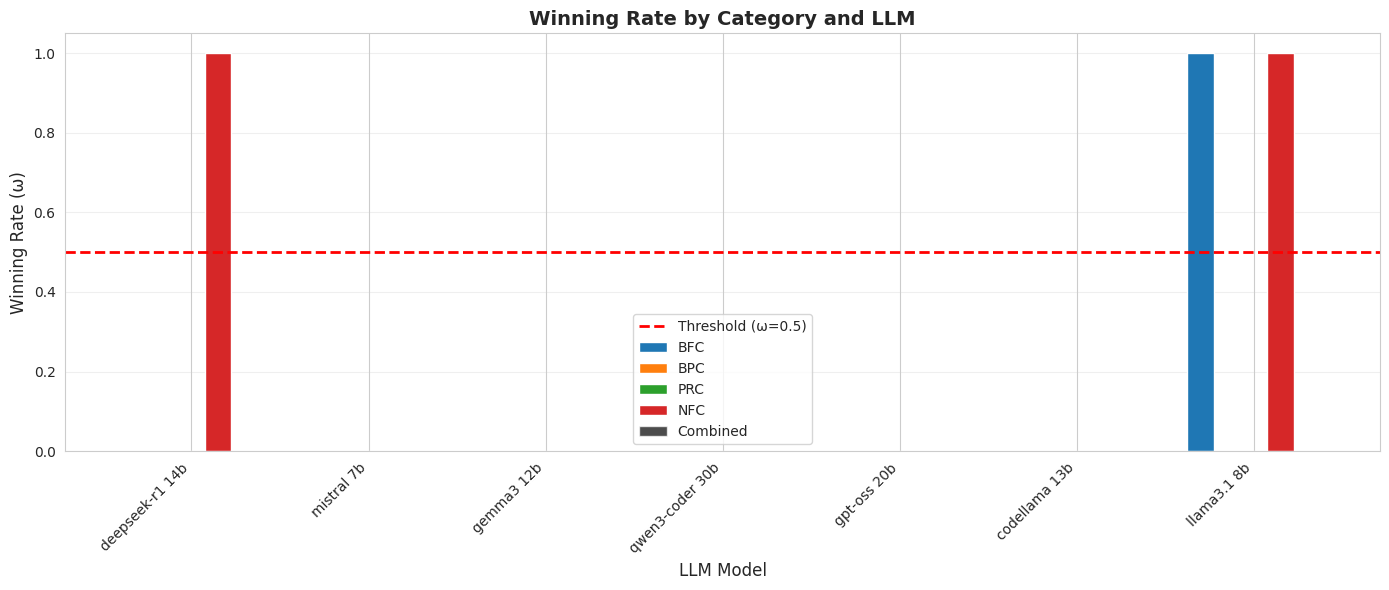

In [17]:
# 1. Winning Rate comparison across categories
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(llm_names))
width = 0.15

for i, category in enumerate(categories):
    df = category_results[category].set_index('LLM').loc[llm_names]
    ax.bar(x + i*width, df['Winning_Rate'], width, label=category.upper())

# Add combined results
combined_df = combined_results_df.set_index('LLM').loc[llm_names]
ax.bar(x + 4*width, combined_df['Winning_Rate'], width, label='Combined', color='black', alpha=0.7)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (ω=0.5)')
ax.set_xlabel('LLM Model', fontsize=12)
ax.set_ylabel('Winning Rate (ω)', fontsize=12)
ax.set_title('Winning Rate by Category and LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x + 2*width)
ax.set_xticklabels(llm_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

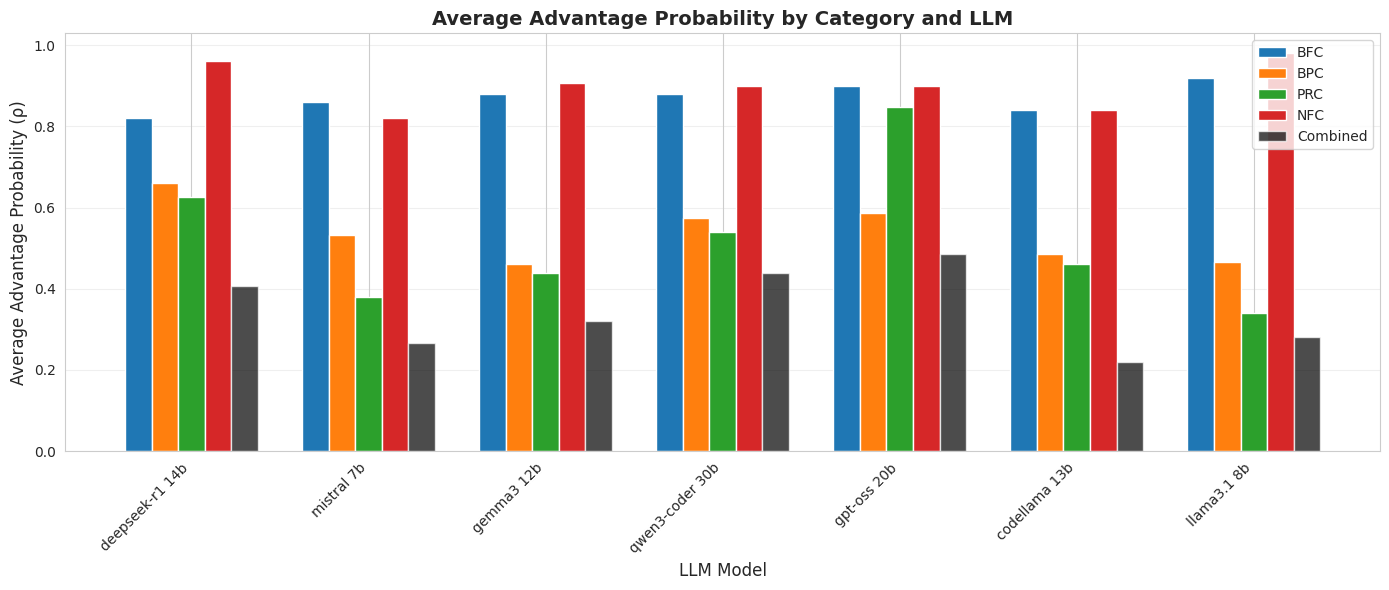

In [18]:
# 2. Average Advantage Probability (ρ) comparison
fig, ax = plt.subplots(figsize=(14, 6))

for i, category in enumerate(categories):
    df = category_results[category].set_index('LLM').loc[llm_names]
    ax.bar(x + i*width, df['Avg_Advantage_Prob'], width, label=category.upper())

combined_df = combined_results_df.set_index('LLM').loc[llm_names]
ax.bar(x + 4*width, combined_df['Avg_Advantage_Prob'], width, label='Combined', color='black', alpha=0.7)

ax.set_xlabel('LLM Model', fontsize=12)
ax.set_ylabel('Average Advantage Probability (ρ)', fontsize=12)
ax.set_title('Average Advantage Probability by Category and LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x + 2*width)
ax.set_xticklabels(llm_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

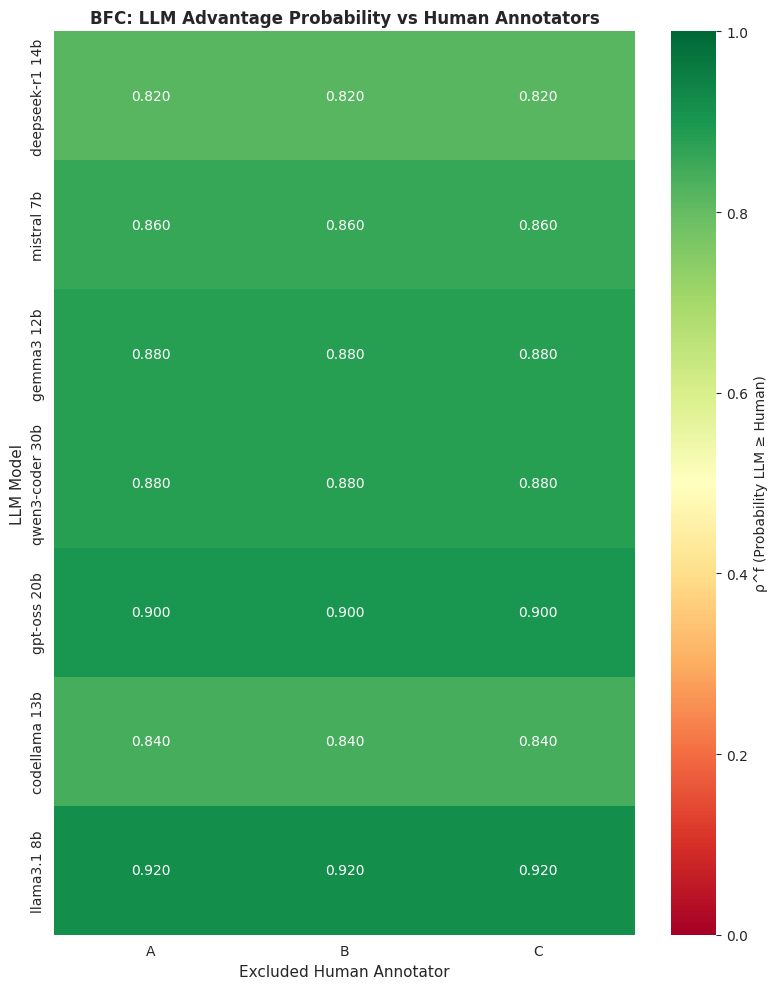

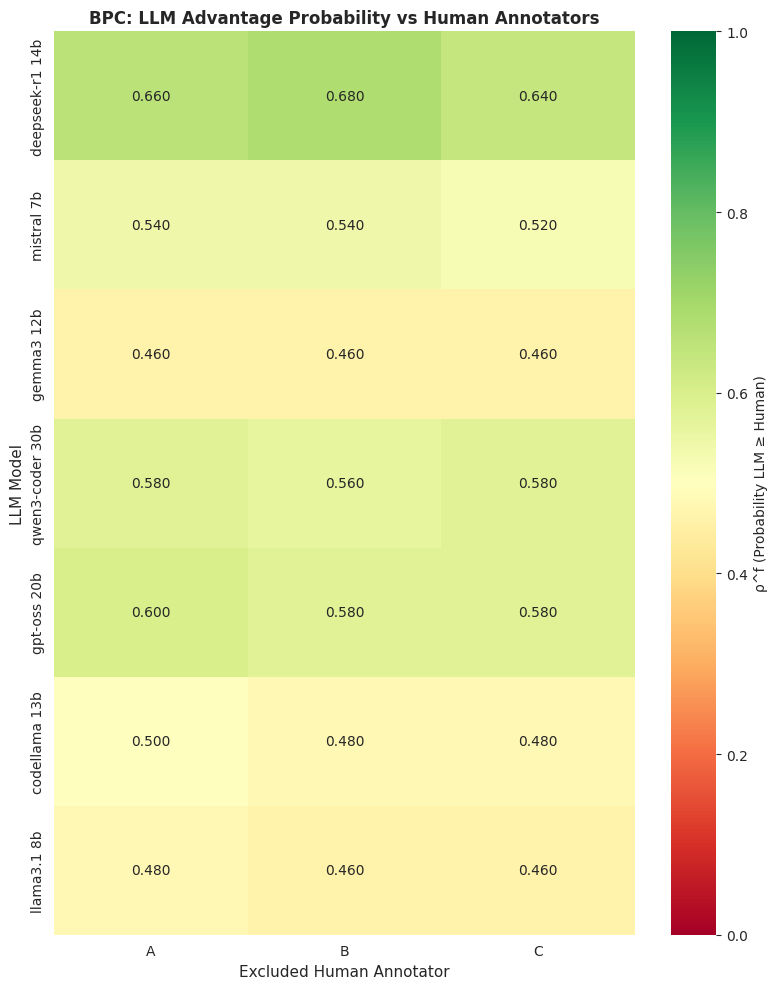

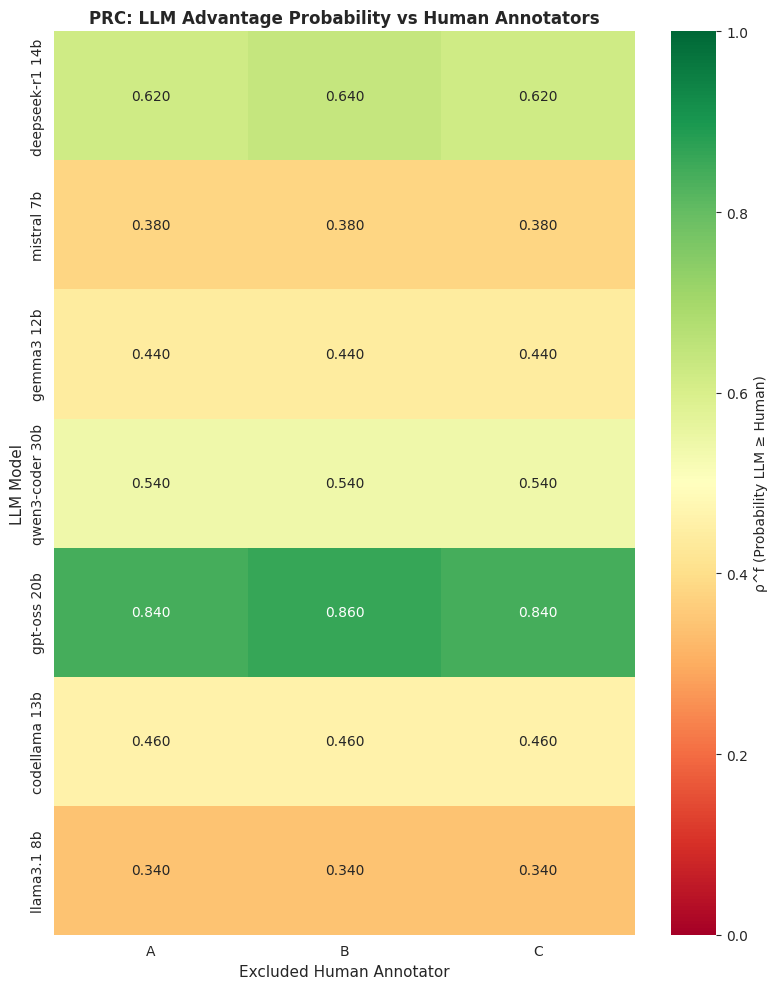

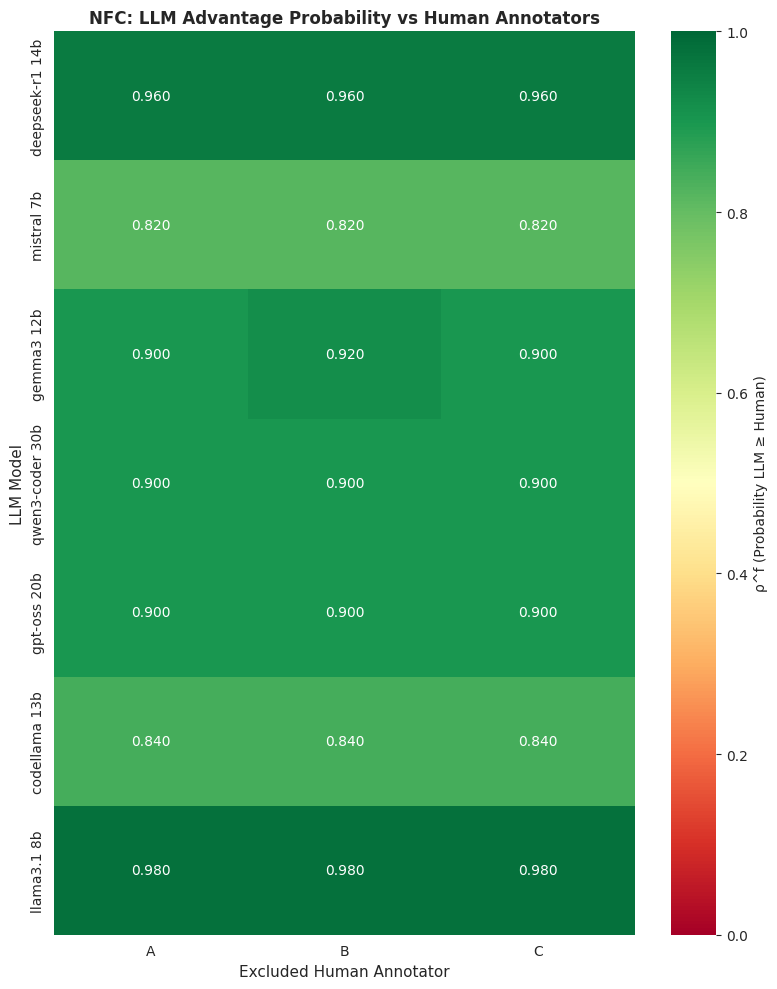

In [19]:
# 3. Heatmap of ρ^f (LLM advantage probability) vs human annotators
for category in categories:
    fig, ax = plt.subplots(figsize=(8, 10))
    
    df = category_results[category]
    
    # Create matrix: rows=LLMs, cols=human annotators
    matrix = np.zeros((len(llm_names), len(human_annotators)))
    for i, llm in enumerate(llm_names):
        for j, human in enumerate(human_annotators):
            matrix[i, j] = df[df['LLM'] == llm][f'rho_f_vs_{human}'].values[0]
    
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                xticklabels=human_annotators, yticklabels=llm_names,
                cbar_kws={'label': 'ρ^f (Probability LLM ≥ Human)'}, ax=ax)
    
    ax.set_title(f'{category.upper()}: LLM Advantage Probability vs Human Annotators', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Excluded Human Annotator', fontsize=11)
    ax.set_ylabel('LLM Model', fontsize=11)
    plt.tight_layout()
    plt.show()

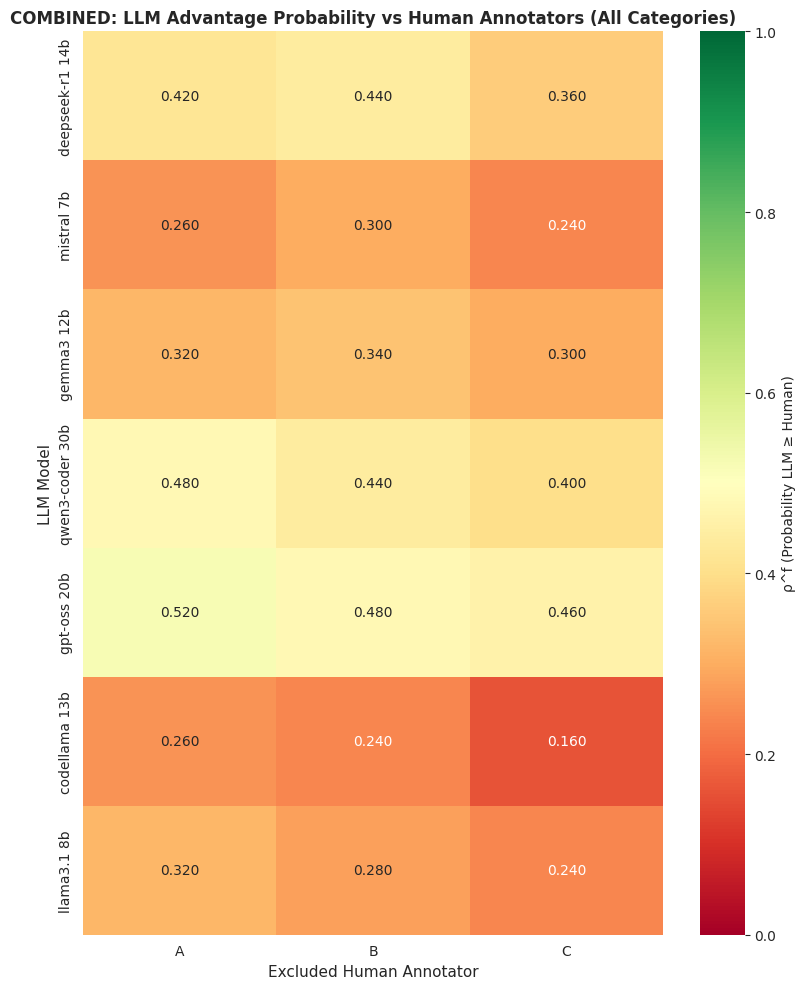

In [20]:
# 4. Combined category heatmap
fig, ax = plt.subplots(figsize=(8, 10))

matrix = np.zeros((len(llm_names), len(human_annotators)))
for i, llm in enumerate(llm_names):
    for j, human in enumerate(human_annotators):
        matrix[i, j] = combined_results_df[combined_results_df['LLM'] == llm][f'rho_f_vs_{human}'].values[0]

sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=human_annotators, yticklabels=llm_names,
            cbar_kws={'label': 'ρ^f (Probability LLM ≥ Human)'}, ax=ax)

ax.set_title('COMBINED: LLM Advantage Probability vs Human Annotators (All Categories)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Excluded Human Annotator', fontsize=11)
ax.set_ylabel('LLM Model', fontsize=11)
plt.tight_layout()
plt.show()

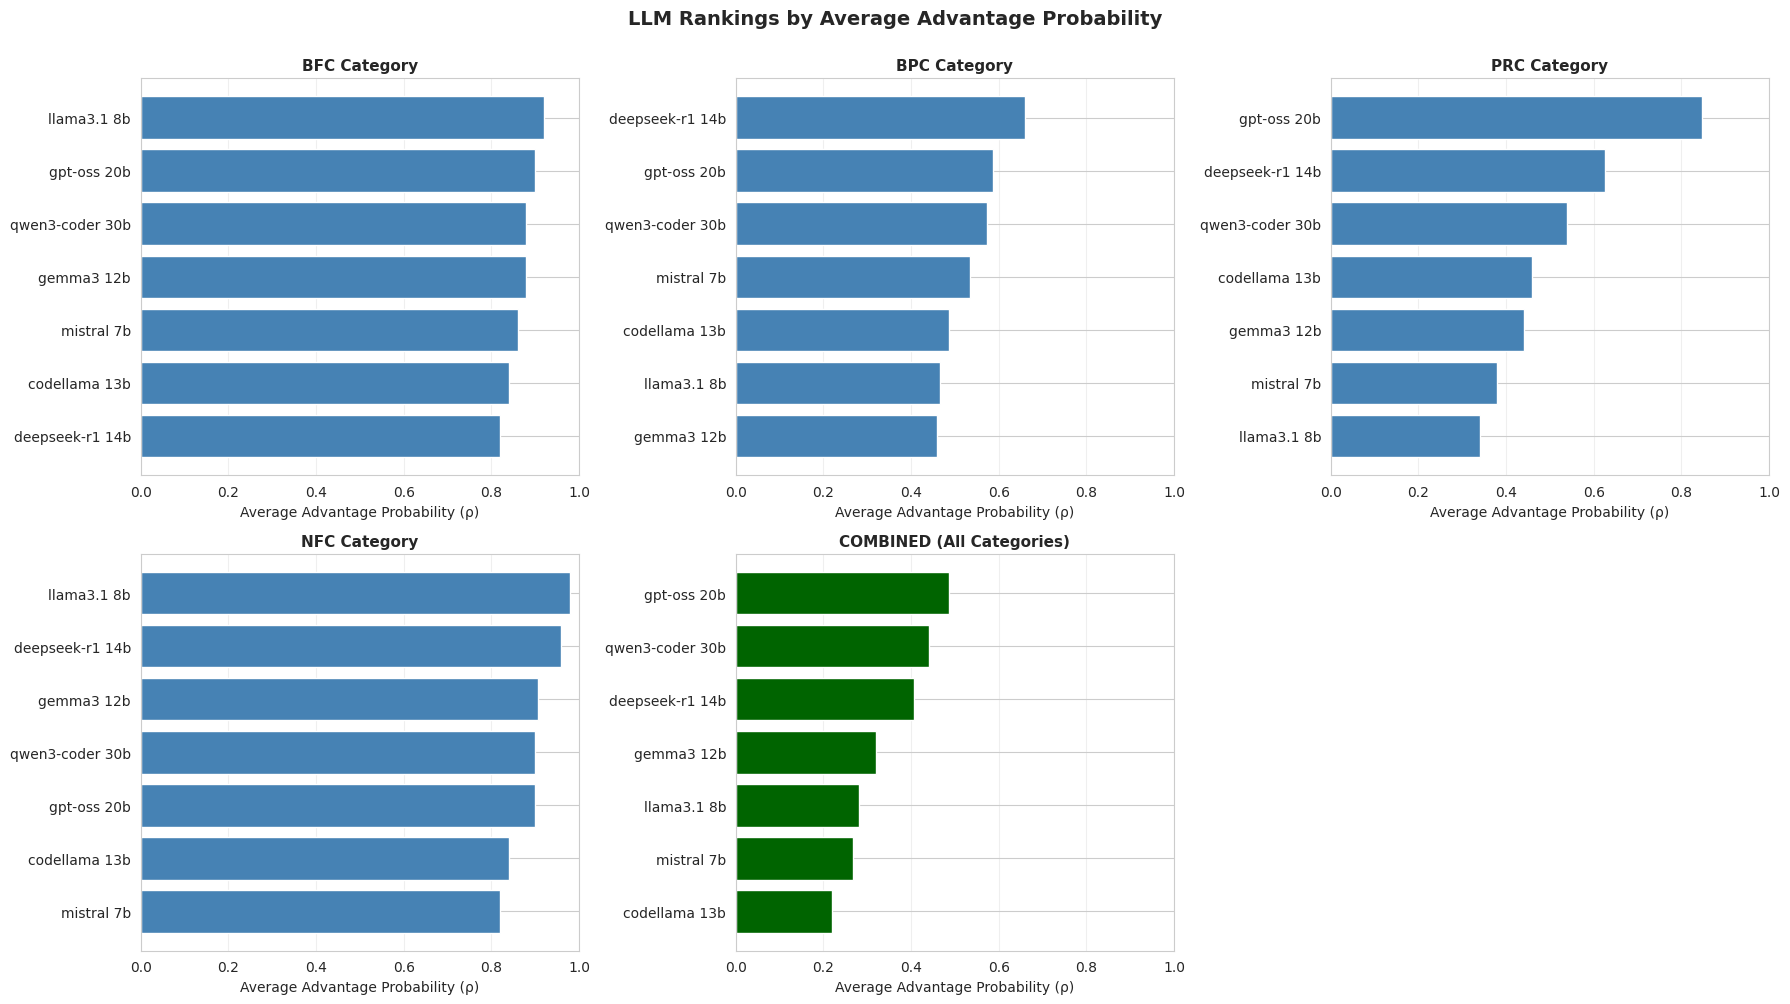

In [21]:
# 5. LLM Ranking by Average Advantage Probability
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Individual categories
for i, category in enumerate(categories):
    df = category_results[category].sort_values('Avg_Advantage_Prob', ascending=True)
    axes[i].barh(df['LLM'], df['Avg_Advantage_Prob'], color='steelblue')
    axes[i].set_xlabel('Average Advantage Probability (ρ)', fontsize=10)
    axes[i].set_title(f'{category.upper()} Category', fontsize=11, fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)
    axes[i].set_xlim([0, 1])

# Combined
df_combined = combined_results_df.sort_values('Avg_Advantage_Prob', ascending=True)
axes[4].barh(df_combined['LLM'], df_combined['Avg_Advantage_Prob'], color='darkgreen')
axes[4].set_xlabel('Average Advantage Probability (ρ)', fontsize=10)
axes[4].set_title('COMBINED (All Categories)', fontsize=11, fontweight='bold')
axes[4].grid(axis='x', alpha=0.3)
axes[4].set_xlim([0, 1])

# Hide the last subplot
axes[5].axis('off')

plt.suptitle('LLM Rankings by Average Advantage Probability', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 8. Epsilon Sensitivity Analysis <a id="8-sensitivity"></a>

We now test how the results change with different epsilon values to validate our choice of ε=0.15.

In [22]:
# Perform sensitivity analysis with different epsilon values
print("Performing epsilon sensitivity analysis...\n")

sensitivity_results = []

for eps in EPSILON_SENSITIVITY:
    print(f"Testing ε = {eps}")
    
    # Test on combined categories
    for llm_name in llm_names:
        adv_probs = compute_combined_advantage_probabilities(
            unified_data, llm_name, human_annotators, categories
        )
        alt_test = perform_alt_test(adv_probs, epsilon=eps, alpha=ALPHA)
        
        sensitivity_results.append({
            'epsilon': eps,
            'LLM': llm_name,
            'Winning_Rate': alt_test['winning_rate'],
            'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
            'Can_Replace': alt_test['can_replace']
        })
    
    print(f"  ε={eps}: {sum(r['Can_Replace'] for r in sensitivity_results if r['epsilon']==eps)}/{len(llm_names)} LLMs can replace")

sensitivity_df = pd.DataFrame(sensitivity_results)

Performing epsilon sensitivity analysis...

Testing ε = 0.1
  ε=0.1: 0/7 LLMs can replace
Testing ε = 0.15
  ε=0.15: 0/7 LLMs can replace
Testing ε = 0.2
  ε=0.2: 0/7 LLMs can replace


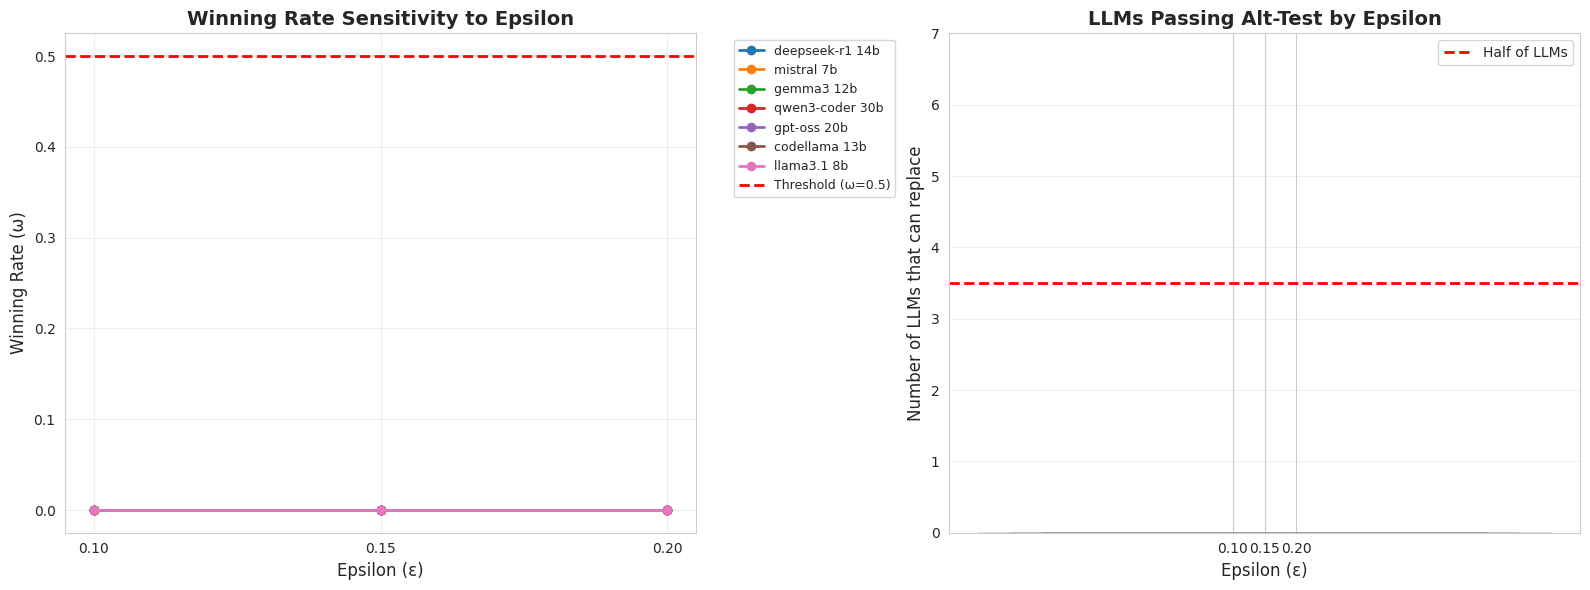

In [23]:
# Visualize sensitivity analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Winning Rate by epsilon
for llm in llm_names:
    llm_data_sens = sensitivity_df[sensitivity_df['LLM'] == llm]
    axes[0].plot(llm_data_sens['epsilon'], llm_data_sens['Winning_Rate'], 
                 marker='o', label=llm, linewidth=2)

axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (ω=0.5)')
axes[0].set_xlabel('Epsilon (ε)', fontsize=12)
axes[0].set_ylabel('Winning Rate (ω)', fontsize=12)
axes[0].set_title('Winning Rate Sensitivity to Epsilon', fontsize=14, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(EPSILON_SENSITIVITY)

# Plot 2: Number of LLMs that can replace by epsilon
can_replace_counts = sensitivity_df.groupby('epsilon')['Can_Replace'].sum()
axes[1].bar(EPSILON_SENSITIVITY, can_replace_counts, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axhline(y=len(llm_names)/2, color='red', linestyle='--', linewidth=2, label='Half of LLMs')
axes[1].set_xlabel('Epsilon (ε)', fontsize=12)
axes[1].set_ylabel('Number of LLMs that can replace', fontsize=12)
axes[1].set_title('LLMs Passing Alt-Test by Epsilon', fontsize=14, fontweight='bold')
axes[1].set_xticks(EPSILON_SENSITIVITY)
axes[1].set_ylim([0, len(llm_names)])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Display sensitivity results table
print("\n" + "="*80)
print("EPSILON SENSITIVITY ANALYSIS RESULTS")
print("="*80)

for eps in EPSILON_SENSITIVITY:
    print(f"\n{'─'*80}")
    print(f"ε = {eps}")
    print(f"{'─'*80}")
    
    eps_results = sensitivity_df[sensitivity_df['epsilon'] == eps].sort_values('Avg_Advantage_Prob', ascending=False)
    
    for idx, row in eps_results.iterrows():
        status = "✓ CAN" if row['Can_Replace'] else "✗ CANNOT"
        print(f"{status:12s} | {row['LLM']:25s} | ω={row['Winning_Rate']:.3f} | ρ={row['Avg_Advantage_Prob']:.3f}")
    
    n_pass = eps_results['Can_Replace'].sum()
    print(f"\nSummary: {n_pass}/{len(llm_names)} LLMs can replace humans with ε={eps}")

print("\n" + "="*80)


EPSILON SENSITIVITY ANALYSIS RESULTS

────────────────────────────────────────────────────────────────────────────────
ε = 0.1
────────────────────────────────────────────────────────────────────────────────
✗ CANNOT     | gpt-oss 20b               | ω=0.000 | ρ=0.487
✗ CANNOT     | qwen3-coder 30b           | ω=0.000 | ρ=0.440
✗ CANNOT     | deepseek-r1 14b           | ω=0.000 | ρ=0.407
✗ CANNOT     | gemma3 12b                | ω=0.000 | ρ=0.320
✗ CANNOT     | llama3.1 8b               | ω=0.000 | ρ=0.280
✗ CANNOT     | mistral 7b                | ω=0.000 | ρ=0.267
✗ CANNOT     | codellama 13b             | ω=0.000 | ρ=0.220

Summary: 0/7 LLMs can replace humans with ε=0.1

────────────────────────────────────────────────────────────────────────────────
ε = 0.15
────────────────────────────────────────────────────────────────────────────────
✗ CANNOT     | gpt-oss 20b               | ω=0.000 | ρ=0.487
✗ CANNOT     | qwen3-coder 30b           | ω=0.000 | ρ=0.440
✗ CANNOT     | deepse

## 9. Conclusions and Interpretation <a id="9-conclusions"></a>

In [25]:
# Generate comprehensive summary
print("="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)
print(f"\n**Epsilon (ε) Used: {EPSILON_PRIMARY}** (skilled annotators)")
print(f"Significance Level (α): {ALPHA}")

print("\n1. OVERALL RESULTS (Combined Categories)")
print("-" * 80)
for idx, row in combined_results_df.iterrows():
    status = "✓ CAN REPLACE" if row['Can_Replace'] else "✗ CANNOT REPLACE"
    print(f"{status:20s} | {row['LLM']:25s} | ω={row['Winning_Rate']:.3f} | ρ={row['Avg_Advantage_Prob']:.3f}")

print("\n2. CATEGORY-SPECIFIC RESULTS")
print("-" * 80)
for category in categories:
    print(f"\n{category.upper()} Category:")
    df = category_results[category]
    can_replace = df[df['Can_Replace'] == True]
    print(f"  {len(can_replace)}/{len(df)} LLMs can replace humans")
    if len(can_replace) > 0:
        best = can_replace.sort_values('Avg_Advantage_Prob', ascending=False).iloc[0]
        print(f"  Best: {best['LLM']} (ρ={best['Avg_Advantage_Prob']:.3f})")

print("\n3. BEST PERFORMING LLMs (by Average Advantage Probability)")
print("-" * 80)
top_3 = combined_results_df.head(3)
for rank, (idx, row) in enumerate(top_3.iterrows(), 1):
    print(f"  #{rank}. {row['LLM']:30s} ρ={row['Avg_Advantage_Prob']:.3f}")

print("\n4. INTERPRETATION")
print("-" * 80)
n_can_replace = combined_results_df['Can_Replace'].sum()
if n_can_replace > 0:
    print(f"✓ {n_can_replace} LLM(s) achieved winning rate ω ≥ 0.5 with ε={EPSILON_PRIMARY}")
    print("  These models can statistically justify replacing a human annotator.")
    print("\n  Winning Rate (ω) interpretation:")
    print("  - ω = proportion of human annotators that the LLM 'beats' in the alt-test")
    print("  - ω ≥ 0.5 means the LLM wins against at least half of the humans")
    print("\n  Average Advantage Probability (ρ) interpretation:")
    print("  - ρ = probability that LLM annotations are ≥ quality of a random human")
    print("  - Higher ρ indicates better overall alignment with human consensus")
else:
    print(f"✗ No LLMs achieved winning rate ω ≥ 0.5 with ε={EPSILON_PRIMARY}")
    print("  None of the tested models can fully replace a human annotator.")
    print(f"  However, best model ({combined_results_df.iloc[0]['LLM']}) has ρ={combined_results_df.iloc[0]['Avg_Advantage_Prob']:.3f}")
    print(f"\n  Note: Try increasing ε to {EPSILON_PRIMARY + 0.05} for a more lenient threshold")

print("\n5. CATEGORY-SPECIFIC STRENGTHS")
print("-" * 80)
for llm in llm_names:
    strengths = []
    for cat in categories:
        df = category_results[cat]
        row = df[df['LLM'] == llm].iloc[0]
        if row['Can_Replace']:
            strengths.append(cat.upper())
    
    if strengths:
        print(f"  {llm:30s}: Strong in {', '.join(strengths)}")

print("\n6. EPSILON (ε) CONSIDERATIONS")
print("-" * 80)
print(f"  Current ε = {EPSILON_PRIMARY} (skilled annotators)")
print("  - Accounts for cost/time savings of using LLMs vs human annotators")
print("  - Chosen based on annotator profile: trained graduate researchers")
print("  - See sensitivity analysis section for impact of different ε values")

print("\n7. LIMITATIONS & CONSIDERATIONS")
print("-" * 80)
print("  - Sample size: 50 commits (limited statistical power)")
print("  - Only 3 human annotators (small baseline)")
print(f"  - Epsilon (ε) = {EPSILON_PRIMARY} chosen for skilled annotators")
print("  - Results specific to Linux kernel commits")
print("  - Different contexts may yield different results")
print("  - Consider domain-specific validation before deployment")

print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)

COMPREHENSIVE ANALYSIS SUMMARY

**Epsilon (ε) Used: 0.15** (skilled annotators)
Significance Level (α): 0.05

1. OVERALL RESULTS (Combined Categories)
--------------------------------------------------------------------------------
✗ CANNOT REPLACE     | gpt-oss 20b               | ω=0.000 | ρ=0.487
✗ CANNOT REPLACE     | qwen3-coder 30b           | ω=0.000 | ρ=0.440
✗ CANNOT REPLACE     | deepseek-r1 14b           | ω=0.000 | ρ=0.407
✗ CANNOT REPLACE     | gemma3 12b                | ω=0.000 | ρ=0.320
✗ CANNOT REPLACE     | llama3.1 8b               | ω=0.000 | ρ=0.280
✗ CANNOT REPLACE     | mistral 7b                | ω=0.000 | ρ=0.267
✗ CANNOT REPLACE     | codellama 13b             | ω=0.000 | ρ=0.220

2. CATEGORY-SPECIFIC RESULTS
--------------------------------------------------------------------------------

BFC Category:
  1/7 LLMs can replace humans
  Best: llama3.1 8b (ρ=0.920)

BPC Category:
  0/7 LLMs can replace humans

PRC Category:
  0/7 LLMs can replace humans

NFC Cate

In [26]:
# Export results to CSV
output_dir = Path('../analysis/results')
output_dir.mkdir(parents=True, exist_ok=True)

epsilon_str = str(EPSILON_PRIMARY).replace('.', '_')

# Save individual category results
for category in categories:
    category_results[category].to_csv(
        output_dir / f'alt_test_results_{category}_eps{epsilon_str}.csv',
        index=False
    )

# Save combined results
combined_results_df.to_csv(
    output_dir / f'alt_test_results_combined_eps{epsilon_str}.csv',
    index=False
)

# Save sensitivity analysis results
sensitivity_df.to_csv(
    output_dir / 'alt_test_sensitivity_analysis.csv',
    index=False
)

print("✓ Results exported to:", output_dir)
print(f"  - alt_test_results_bfc_eps{epsilon_str}.csv")
print(f"  - alt_test_results_bpc_eps{epsilon_str}.csv")
print(f"  - alt_test_results_prc_eps{epsilon_str}.csv")
print(f"  - alt_test_results_nfc_eps{epsilon_str}.csv")
print(f"  - alt_test_results_combined_eps{epsilon_str}.csv")
print("  - alt_test_sensitivity_analysis.csv")

✓ Results exported to: ../analysis/results
  - alt_test_results_bfc_eps0_15.csv
  - alt_test_results_bpc_eps0_15.csv
  - alt_test_results_prc_eps0_15.csv
  - alt_test_results_nfc_eps0_15.csv
  - alt_test_results_combined_eps0_15.csv
  - alt_test_sensitivity_analysis.csv
